In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn
import torch
from torchinterp1d import Interp1d
from lsh import LSH
import matplotlib.pyplot as plt
import sklearn
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df_train = pd.read_csv("../dataset/pointcloud_mnist_2d/train.csv")
df_test = pd.read_csv("../dataset/pointcloud_mnist_2d/test.csv")

In [3]:
X = df_train[df_train.columns[1:]].to_numpy()
y = df_train[df_train.columns[0]].to_numpy()
X = X.reshape(X.shape[0], -1, 3)

In [4]:
sample_dataset = []
for i in range(X.shape[0]):
    sample = X[i, :, :]
    sample = sample[sample[:, 2] > 0][:, :2]
    sample_dataset.append(sample)

In [5]:
class SWE:
    def __call__(self, dataset, reference, L, slicer_fn='linear', random_state=0):
        '''Inputs:
                dataset(N*dim): input dataset of N elements
                reference(M*dim): reference set (empirical distribution) of M elements
                slicer_fn: slicer for the generalized swd
                L: number of slices
        '''
        assert dataset.shape[-1]==reference.shape[-1]
        self.dim = dataset.shape[-1]
        
        self.N = dataset.shape[0]
        self.M = reference.shape[0]
        self.num_slices = L
        if slicer_fn=='linear':
            self.slicer = self.linear_slicer
        else: raise Exception('Slicer function not defined')
        self.state = random_state
        
        return self.sw_embedding(dataset, reference)
    
    def generate_theta(self, d, L):
        '''This function generates a set of L parameters sampled uniformly from
           dim-dimensional unit hypersphere.
           The shape of \theta is L*dim.
        '''
        torch.manual_seed(self.state)
        theta = [th_ / torch.sqrt(torch.sum((th_**2))) for th_ in torch.randn(L, d)]
    
        return torch.stack(theta, dim=0)
    
    def get_slices(self, X):
        '''This function uses the given slicer and theta to get the slices of the 
           dataset or reference set.
           The shape of slices is (N,L).
        '''
        theta = self.generate_theta(self.dim, self.num_slices)
        
        return self.slicer(X, theta)
    
    def interpolation(self, data_sorted, permutation):
        '''In general N != M, in which case the Monge coupling is obtained via linear interpolation*.
           *https://github.com/aliutkus/torchinterp1d
           Inputs:
                data_sorted: the sorted data slices (shape: K*N*L)
                permutation: the ordering that permutes the sorted set back based on the sorting of 
                             the reference set (shape: M*L)
        '''
        #cdf of sorted dataset.
        Fx = 1 / self.N * torch.arange(1, self.N+1).repeat(self.num_slices,1).T
        #cdf of reference set
        z = 1/self.M*(torch.add(permutation,1))
        #evaluate the inverse of cdf of data_sorted at z
        interp = Interp1d()(Fx.T, data_sorted.T, z.T)

        # return the monge copuling with shape K*M*L
        return interp.T

    def monge_coupling(self, dataset, reference):
        '''This function calculates the monge coupling of the dataset and the reference set by slicing, sorting
           and coupling. The dimensionality of the Monge coupling is K*M*L.
        '''
        sliced_data = self.get_slices(dataset)
        sliced_ref = self.get_slices(reference)
        
        data_sorted,_ = torch.sort(sliced_data, dim=1)
        ref_ind = torch.argsort(sliced_ref, dim=0)
        permutation = torch.argsort(ref_ind, dim=0)
        
        coupling = self.interpolation(data_sorted, permutation)
        
        return coupling
        
    def sw_embedding(self, dataset, reference):
        
        M = torch.tensor(reference.shape[0])
        #return the final embedding
        return 1/torch.sqrt(M)*(self.monge_coupling(dataset, reference)-self.get_slices(reference))
    
    def linear_slicer(self, X, theta):
        #g_\theta(x)=\theta^T*x
        if len(theta.shape)==1:
            return torch.matmul(X,theta)
        else:
            return torch.matmul(X,theta.T)

In [6]:
point_cloud = np.concatenate(sample_dataset, axis=0)

In [7]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(point_cloud)

In [8]:
ref = torch.FloatTensor(kmeans.cluster_centers_)

In [9]:
sample_dataset = [torch.from_numpy(sample).to(torch.float) for sample in sample_dataset]

In [10]:
phi = []
for sample in sample_dataset:
    v = SWE()(sample,ref,20)
    phi.append(v)
    
phi = torch.stack(phi, dim=0)
phi.shape

torch.Size([60000, 10, 20])

torch.Size([60000, 10, 20])

In [11]:
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(phi.reshape(phi.shape[0],-1), y)

KNeighborsClassifier(n_neighbors=10)

KNeighborsClassifier(n_neighbors=10)

In [12]:
X_test = df_test[df_test.columns[1:]].to_numpy()
y_test = df_test[df_test.columns[0]].to_numpy()
X_test = X_test.reshape(X_test.shape[0], -1, 3)
X_test = torch.from_numpy(X_test).to(torch.float)
y_test = torch.from_numpy(y_test).to(torch.float)
test_dataset = []
for i in range(X_test.shape[0]):
    test = X_test[i, :, :]
    test = test[test[:, 2] > 0][:, :2]
    test_dataset.append(test)

In [13]:
psi = []
for test in test_dataset:
    w = SWE()(test,ref,20)
    psi.append(w)
psi = torch.stack(psi, dim=0)

In [14]:
preds = neigh.predict(psi.reshape(psi.shape[0],-1))

In [15]:
accuracy_score(preds,y_test)

0.1812

0.1812

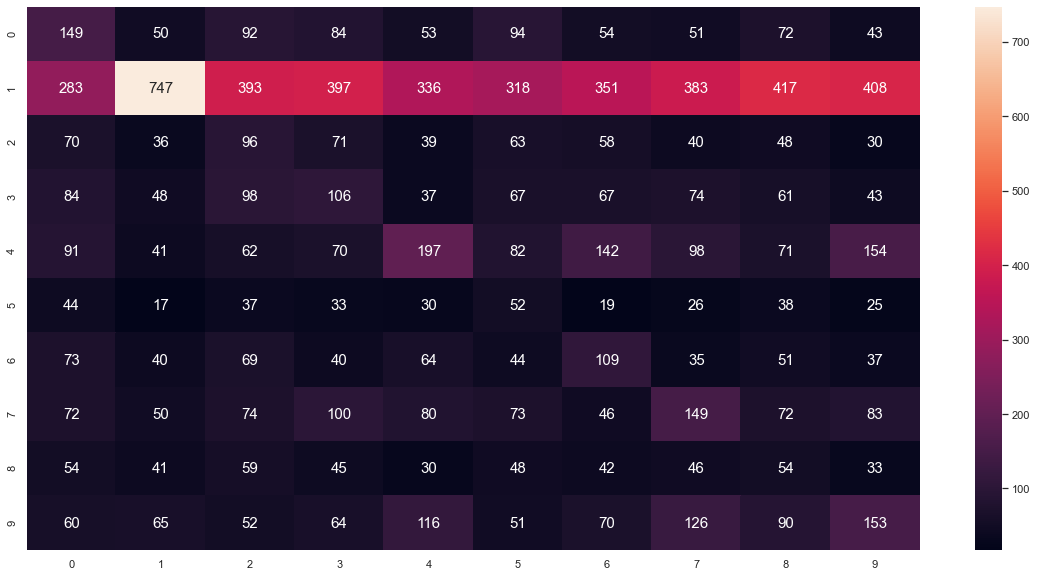

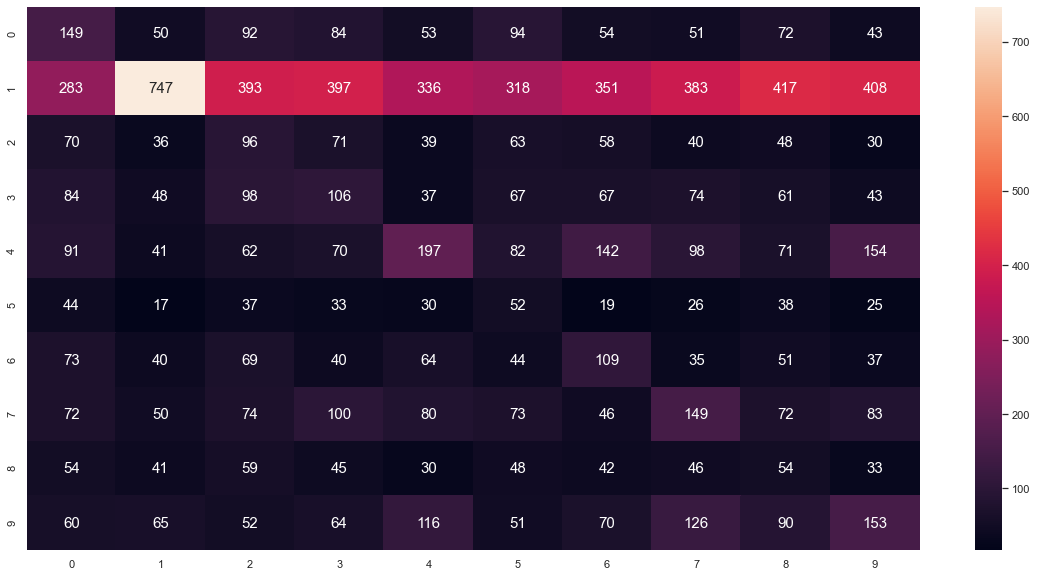

In [16]:
cm = confusion_matrix(preds,y_test)

df_cm = pd.DataFrame(cm, range(10), range(10))
plt.figure(figsize=(20,10))
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}, fmt='g')

plt.show()